# Example 2

In [1]:
import SimpleITK as sitk
import os

## Helper function

In [2]:
def save_transform_and_image(transform, fixed_image, moving_image, outputfile_prefix):
    """
    Write the given transformation to file, resample the moving_image onto the fixed_images grid and save the
    result to file.

    Args:
        transform (SimpleITK Transform): transform that maps points from the fixed image coordinate system to the moving.
        fixed_image (SimpleITK Image): resample onto the spatial grid defined by this image.
        moving_image (SimpleITK Image): resample this image.
        outputfile_prefix (string): transform is written to outputfile_prefix.tfm and resampled image is written to outputfile_prefix.mha.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)

    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetTransform(transform)
    sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix + ".mha")
    sitk.WriteTransform(transform, outputfile_prefix + ".tfm")

def print_image_info(img):
    print(f"Size:      {img.GetSize()}")
    print(f"Spacing:   {img.GetSpacing()}")
    print(f"PixelID: {img.GetPixelID()}")
    print()

## Load Data

In [3]:
fixed_image = sitk.ReadImage("fixedImage.mha")
moving_image = sitk.ReadImage("preAlignment.mha")

print_image_info(fixed_image)
print_image_info(moving_image)

Size:      (512, 512, 283)
Spacing:   (0.65625, 0.65625, 0.625)
PixelID: 4

Size:      (320, 240, 352)
Spacing:   (1.1875, 1.1875, 1.0)
PixelID: 3



## Initial Alignment

In [6]:
initial_transform = sitk.CenteredTransformInitializer(
    fixedImage = sitk.Cast(fixed_image, moving_image.GetPixelID()),
    movingImage = moving_image, 
    transform = sitk.Euler3DTransform(),
    operationMode = sitk.CenteredTransformInitializerFilter.GEOMETRY # MOMENTS
)

save_transform_and_image(initial_transform, fixed_image, moving_image, os.path.join("output", "initialAlignment"),)

print(type(initial_transform))

<class 'SimpleITK.SimpleITK.Transform'>


## Final Registration

### Version 1.1

In [9]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100)
# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift()

registration_method.SetInitialTransform(initial_transform, inPlace=False)

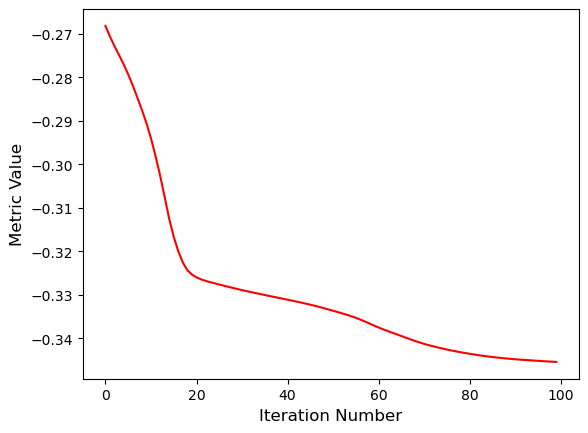

In [10]:
# Optional Drawing
import registration_callbacks
registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: registration_callbacks.metric_plot_values(registration_method),)

final_transform_v11 = registration_method.Execute(
    fixed=sitk.Cast(fixed_image, sitk.sitkFloat32), 
    moving=sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [11]:
print(f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}")
print(f"Final metric value: {registration_method.GetMetricValue()}")

save_transform_and_image(final_transform_v11, fixed_image, moving_image, os.path.join("Output", "finalAlignment-v11"),)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Final metric value: -0.3454661929755809


In [13]:
print(final_transform_v11)

itk::simple::CompositeTransform
 CompositeTransform (000002064F7A8A40)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1500544
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (000002064F168B30)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1500534
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998448 0.0312868 -0.0460802 
       -0.0309908 0.999494 0.00712404 
       0.0462798 -0.00568492 0.998912 
     Offset: [11.0099, 40.7636, 79.2895]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [15.9249, 40.0125, 79.3925]
     Inverse: 
       0.998448 -0.0309908 0.0462798 
       0.0312868 0.999494 -0.00568492 
       -0.0460802 0.00712404 0.998912 
     Singular: 0
     Euler's angles: AngleX=-0.00568495 AngleY=-0.0462971 AngleZ=-0.0312924
     m_Co

### Version 1.2

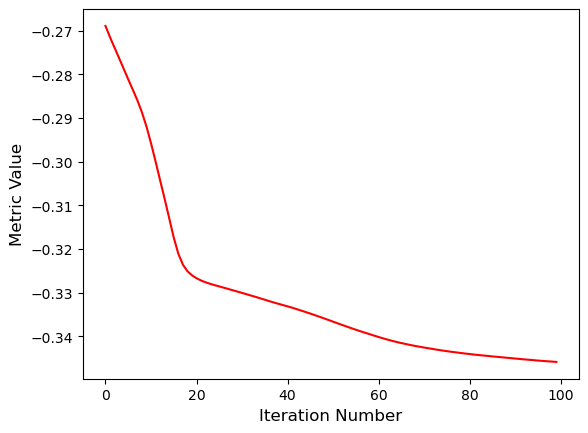

In [14]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()
registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransform(optimized_transform)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))

# Need to compose the transformations after registration.
final_transform_v12 = sitk.CompositeTransform(optimized_transform)
final_transform_v12.AddTransform(initial_transform)

In [17]:
print(f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}")
print(f"Final metric value: {registration_method.GetMetricValue()}")

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(final_transform_v11, fixed_image, moving_image, os.path.join("output", "finalAlignment-v1.1"),)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Final metric value: -0.3458930965077362


In [18]:
print(final_transform_v12)

itk::simple::CompositeTransform
 CompositeTransform (000002064F7A8BD0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 2998966
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000020638BC0480)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 3
     Modified Time: 2998942
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998478 0.0301381 -0.0461825 
       -0.0299219 0.999538 0.00536592 
       0.0463229 -0.00397589 0.998919 
     Offset: [-8.97013, 11.551, -4.57627]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [-4.04377, 10.9875, -4.47459]
     Inverse: 
       0.998478 -0.0299219 0.0463229 
       0.0301381 0.999538 -0.00397589 
       -0.0461825 0.00536592 0.998919 
     Singular: 0
     Euler's angles: AngleX=-0.0039759 AngleY=-0.0463398 AngleZ=-0.0301429
     m_

### version 2

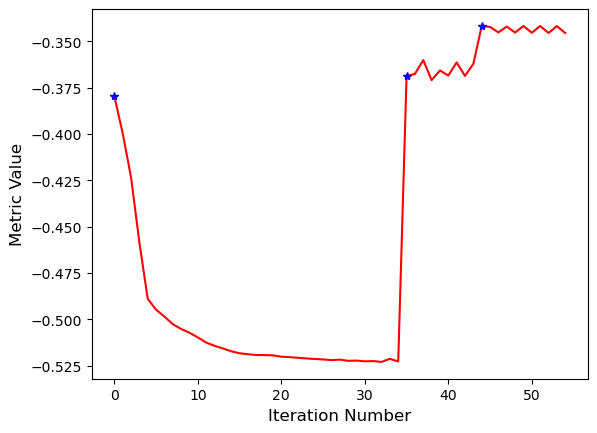

<SimpleITK.SimpleITK.Euler3DTransform; proxy of <Swig Object of type 'itk::simple::Euler3DTransform *' at 0x000002067A8074B0> >

In [19]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)

registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, registration_callbacks.metric_update_multires_iterations,)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: registration_callbacks.metric_plot_values(registration_method),)

registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))

In [20]:
print(f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}")
print(f"Final metric value: {registration_method.GetMetricValue()}")

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(final_transform, fixed_image, moving_image, os.path.join("Output", "finalAlignment-v2"),)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.
Final metric value: -0.3416316934356154


In [21]:
print(final_transform)

itk::simple::Euler3DTransform
 Euler3DTransform (0000020638BC29A0)
   RTTI typeinfo:   class itk::Euler3DTransform<double>
   Reference Count: 3
   Modified Time: 4697437
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.998279 0.0372239 -0.045319 
     -0.0369718 0.999296 0.00638742 
     0.0455249 -0.00470089 0.998952 
   Offset: [10.6713, 39.7285, 79.279]
   Center: [-0.328125, -0.328125, -106.875]
   Translation: [15.5031, 39.0582, 79.3776]
   Inverse: 
     0.998279 -0.0369718 0.0455249 
     0.0372239 0.999296 -0.00470089 
     -0.045319 0.00638742 0.998952 
   Singular: 0
   Euler's angles: AngleX=-0.00470091 AngleY=-0.0455411 AngleZ=-0.0372329
   m_ComputeZYX = 0

